In [1]:
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] ='0'
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.current_device())

True
1
NVIDIA GeForce RTX 3060
0


In [2]:
import re
import pandas as pd
import copy
import numpy as np
import evaluate
from docx import Document
import os
import torch
from transformers import BertModel, BertTokenizerFast
import torch.nn.functional as F
class DataLoader:
    """
    Loader for benchmarking datasets to ensure universal formatting. To be used in conjunction with DyslexiaInjector.
    ...
    Attributes
    ----------
    path: str
        Path to csv, txt or docx file of the data. In the case of CSV there should only be 1 column
    data: list
        A list of striings
    dataset_name: str
        Name of the dataset that is used when saving the data
        
    Methods
    -------
    save_as_txt(path):
        Saves data as a text file to specified path
    save_as_csv(path):
        Saves data as a csv file to specified path
    get_data():
        Returns data
    create_deepcopy():
        Returns a deep copy of the class instance
    get_name():
        returns name of the dataset (dataset_name)
    
    Usage
    -------
    >>> from datasets import load_dataset
    >>> from DataLoader import DataLoader
    >>> dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
    >>> to_translate = []
    >>> for i in range(len(dataset_wmt_enfr)):
    >>>     to_translate.append(dataset_wmt_enfr[i]['translation']['en'])
    >>> loader = DataLoader(data=to_translate, dataset_name="wmt14_enfr")
    >>> loader.save_as_txt("wmt14_enfr.txt")
    We can also use the text file to create a new DataLoader instance
    >>> loader2 = DataLoader(path="wmt14_enfr.txt", dataset_name="wmt14_enfr")
    """
    # Constructor
    def __init__(self, path=None, data=None, dataset_name=""):
        self.dataset_name = dataset_name
        if data is None and path is not None:
            #check path to see if file is txt or csv
            file_type = path.split(".")[-1]
            if file_type == "txt":
                self.data = self.parse_txt(path)
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "csv":
                self.data = pd.read_csv(path, header=None)
                self.data = self.data[0].tolist()
                #fix any formatting issues
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "docx":
                doc = Document(path)
                self.data = [self.fix_format(paragraph.text) for paragraph in doc.paragraphs]
            else:
                raise Exception("Invalid file type")
        elif data is not None:
            #check if data is a list or a df
            if isinstance(data, list):
                #format each sentence in data
                self.data = [self.fix_format(sentence) for sentence in data]
            else:
                raise Exception("Invalid data type, please pass in a list of sentences")
        else:
            raise Exception("Please pass in a path or data")

    def parse_txt(self, path):
        output = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                output.append(self.fix_format(line))
        return output
                
    def fix_format(self, sentence):
        #remove spacing before punctuation
        sentence = re.sub(r'\s([?.!,"](?:\s|$))', r'\1', sentence)
        #replace any double spaces with single space
        sentence = re.sub(r'\s+', ' ', sentence)
        #remove any leading or trailing spaces
        sentence = sentence.strip()
        #make all quotes (german and french) english double quotes
        sentence = re.sub(r'«|»|„|“', '"', sentence)
        #make all single quotes english single quotes
        sentence = re.sub(r'‘|’', "'", sentence)
        #make all french guillemets english double quotes
        sentence = re.sub(r'‹|›', '"', sentence)
        #if sentence begins and ends with quotes and there are only two, remove them
        if sentence[0] == '"' and sentence[-1] == '"' and sentence.count('"') == 2:
            sentence = sentence[1:-1]
        elif sentence[0] == "'" and sentence[-1] == "'" and sentence.count("'") == 2:
            sentence = sentence[1:-1]
        return sentence

    def save_as_txt(self, path):
        with open(path, "w", encoding="utf-8") as f:
            for sentence in self.data:
                f.write(f"{sentence}\n")
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_csv(self, path):
        df = pd.DataFrame(self.data)
        df.to_csv(path, index=False, header=False, encoding='utf-8')
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_docx(self, path):
        document = Document()
        for sentence in self.data:
            document.add_paragraph(sentence)
        document.save(path)
        print(f"Saved {self.dataset_name} to {path}")
        return

    def get_data(self):
        return self.data

    def create_deepcopy(self):
        return DataLoader(data=copy.deepcopy(self.data), dataset_name=self.dataset_name)
        
    def get_name(self):
        return self.dataset_name

    def get_number_of_sentences(self):
        return len(self.data)
    
    def get_number_of_words(self):
        return sum([len(sentence.split()) for sentence in self.data])
    
    def get_number_of_letters(self):
        #need to ensure we only count letters and not punctuation
        return sum([len(re.sub(r'[^\w\s]','',sentence)) for sentence in self.data])

    def edit_distance(reference_sentence, sentence):
        """
        Returns the number of edits required to transform reference_sentence into sentence at word level
        edits include insertions, deletions and substitutions
        based on levenshtein distance
        also returns a dictionary of substitutions, insertions and deletions
        """
        substitutions = 0
        insertions = 0
        deletions = 0
        substitution_dict = {}
        insertion_dict = {}
        deletion_dict = {}
        #remove punctuation and split into words
        sentence = re.sub(r'[^\w\s]','',sentence).lower().split()
        reference_sentence = re.sub(r'[^\w\s]','',reference_sentence).lower().split()
        #create matrix
        matrix = np.zeros((len(reference_sentence)+1,len(sentence)+1))
        #fill in first row and column
        for i in range(len(reference_sentence)+1):
            matrix[i][0] = i
        for j in range(len(sentence)+1):
            matrix[0][j] = j
        #fill in rest of matrix
        for i in range(1,len(reference_sentence)+1):
            for j in range(1,len(sentence)+1):
                if sentence[j-1] == reference_sentence[i-1]:
                    matrix[i][j] = matrix[i-1][j-1]
                else:
                    matrix[i][j] = min(matrix[i-1][j-1], matrix[i-1][j], matrix[i][j-1])+1
        #backtrack to find edits
        i = len(reference_sentence)
        j = len(sentence)
        while i > 0 and j > 0:
            if sentence[j-1] == reference_sentence[i-1]:
                i -= 1
                j -= 1
            else:
                if matrix[i][j] == matrix[i-1][j-1]+1:
                    substitutions += 1
                    if reference_sentence[i-1] not in substitution_dict:
                        substitution_dict[reference_sentence[i-1]] = {sentence[j-1]:1}
                    else:
                        if sentence[j-1] not in substitution_dict[reference_sentence[i-1]]:
                            substitution_dict[reference_sentence[i-1]][sentence[j-1]] = 1
                        else:
                            substitution_dict[reference_sentence[i-1]][sentence[j-1]] += 1
                    i -= 1
                    j -= 1
                elif matrix[i][j] == matrix[i-1][j]+1:
                    deletions += 1
                    if reference_sentence[i-1] not in deletion_dict:
                        deletion_dict[reference_sentence[i-1]] = 1
                    else:
                        deletion_dict[reference_sentence[i-1]] += 1
                    i -= 1
                elif matrix[i][j] == matrix[i][j-1]+1:
                    insertions += 1
                    if sentence[j-1] not in insertion_dict:
                        insertion_dict[sentence[j-1]] = 1
                    else:
                        insertion_dict[sentence[j-1]] += 1
                    j -= 1
        while i > 0:
            deletions += 1
            if reference_sentence[i-1] not in deletion_dict:
                deletion_dict[reference_sentence[i-1]] = 1
            else:
                deletion_dict[reference_sentence[i-1]] += 1
            i -= 1
        while j > 0:
            insertions += 1
            if sentence[j-1] not in insertion_dict:
                insertion_dict[sentence[j-1]] = 1
            else:
                insertion_dict[sentence[j-1]] += 1
            j -= 1
        return substitutions, insertions, deletions, substitution_dict, insertion_dict, deletion_dict
        
    def get_edit_distance(self, reference):
        """
        Returns the number of edits required to transform data into reference at word level
        edits include insertions, deletions and substitutions
        based on levenshtein distance
        """
        if type(reference) == list:
            substitutions = 0
            insertions = 0
            deletions = 0
            all_sub = {}
            all_ins = {}
            all_del = {}
            for i in range(len(self.data)):
                sub, ins, dele, substitution_dict, insertion_dict, deletion_dict = DataLoader.edit_distance(reference[i], self.data[i], )
                all_sub = self.combine_nested_dict(all_sub, substitution_dict)
                all_ins = self.combine_dicts(all_ins, insertion_dict)
                all_del = self.combine_dicts(all_del, deletion_dict)
                substitutions += sub
                insertions += ins
                deletions += dele
            return substitutions, insertions, deletions, all_sub, all_ins, all_del
        elif type(reference) == DataLoader:
            return self.get_edit_distance(reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def combine_nested_dict(self, dict1, dict2):
        for key in dict2:
            if key not in dict1:
                dict1[key] = dict2[key]
            else:
                for key2 in dict2[key]:
                    if key2 not in dict1[key]:
                        dict1[key][key2] = dict2[key][key2]
                    else:
                        dict1[key][key2] += dict2[key][key2]
        return dict1
    
    def combine_dicts(self, dict1, dict2):
        for key in dict2:
            if key not in dict1:
                dict1[key] = dict2[key]
            else:
                dict1[key] += dict2[key]
        return dict1

    def get_bleue_score(self, reference):
        #returns bleu score of the data against a reference
        bleu = evaluate.load("bleu")
        if type(reference) == list:
            return bleu.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return bleu.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_wer(self, reference):
        #returns wer score of the data against a reference
        wer = evaluate.load("wer")
        if type(reference) == list:
            return wer.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return wer.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_bleurt_score(self, reference):
        #returns bleurt score of the data against a reference
        bleurt = evaluate.load("bleurt")
        if type(reference) == list:
            return bleurt.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return bleurt.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")
            
    def get_bert_score(self, reference):
        #returns bert score of the data against a reference
        bert = evaluate.load("bertscore")
        if type(reference) == list:
            return bert.compute(predictions=self.data, references=reference, lang="fr")
        elif type(reference) == DataLoader:
            return bert.compute(predictions=self.data, references=reference.get_data(), lang="fr")
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def similarity(self, embeddings_1, embeddings_2):
        normalized_embeddings_1 = F.normalize(embeddings_1, p=2)
        normalized_embeddings_2 = F.normalize(embeddings_2, p=2)
        res = torch.matmul(
            normalized_embeddings_1, normalized_embeddings_2.transpose(0, 1)
        )
        #only keep the diagonal values
        res = res.diag()
        return res

    def get_LaBSE(self, reference, model=None, tokenizer=None):
        """
        Returns the LaBSE similarity score of the data against a reference which is a l2 norm between the reference and target sentences score.
        Score of 1 means the sentences are identical, closer to 0 means they are less similar semantically.
        """
        if model is None:
            model = BertModel.from_pretrained("setu4993/LaBSE")
        if tokenizer is None:
            tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
        if type(reference) == list:
            pass
        elif type(reference) == DataLoader:
            reference = reference.get_data()
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")
        target = self.data
        reference_inputs = tokenizer(reference, return_tensors="pt", padding=True).to("cuda")
        target_inputs = tokenizer(target, return_tensors="pt", padding=True).to("cuda")
        with torch.no_grad():
            reference_outputs = model(**reference_inputs)
            target_outputs = model(**target_inputs)
        reference_embeddings = reference_outputs.pooler_output
        target_embeddings = target_outputs.pooler_output
        return self.similarity(reference_embeddings, target_embeddings)


c:\Users\gerge\anaconda3\envs\Dyslexia_Research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#need to loop through file directory
aws_data_v1 = []
aws_data_v2 = []
for filename in os.listdir("to_test/v1/aws"):
    temp = DataLoader(path="to_test/v1/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v1.append(temp)

for filename in os.listdir("to_test/v2/aws"):
    temp = DataLoader(path="to_test/v2/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v2.append(temp)

azure_data_v1 = []
for filename in os.listdir("to_test/v1/azure"):
    temp = DataLoader(path="to_test/v1/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v1.append(temp)

azure_data_v2 = []
for filename in os.listdir("to_test/v2/azure"):
    temp = DataLoader(path="to_test/v2/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v2.append(temp)

google_data_v1 = []
for filename in os.listdir("to_test/v1/google"):
    temp = DataLoader(path="to_test/v1/google/"+filename, dataset_name="google_"+filename)
    google_data_v1.append(temp)

google_data_v2 = []
for filename in os.listdir("to_test/v2/google"):
    temp = DataLoader(path="to_test/v2/google/"+filename, dataset_name="google_"+filename)
    google_data_v2.append(temp)

gpt_data_v1 = []
for filename in os.listdir("to_test/v1/gpt"):
    temp = DataLoader(path="to_test/v1/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v1.append(temp)

gpt_data_v2 = []
for filename in os.listdir("to_test/v2/gpt"):
    temp = DataLoader(path="to_test/v2/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v2.append(temp)

from datasets import load_dataset
dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
to_translate_wmt14_en = []
reference_wmt14_fr = []

for i in range(len(dataset_wmt_enfr)):
    to_translate_wmt14_en.append(dataset_wmt_enfr[i]['translation']['en'])
    reference_wmt14_fr.append(dataset_wmt_enfr[i]['translation']['fr'])

reference_corpus_fr = DataLoader(data=reference_wmt14_fr, dataset_name="wmt14_fr")
reference_corpus_en = DataLoader(data=to_translate_wmt14_en, dataset_name="wmt14_en")


c:\Users\gerge\anaconda3\envs\Dyslexia_Research\lib\site-packages\datasets\load.py:1429: FutureWarning: The repository for wmt14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wmt14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [14]:
model = BertModel.from_pretrained("setu4993/LaBSE")
tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")

In [15]:
#load model to gpu
device = torch.device("cuda")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(501153, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [16]:
aws_baseline = aws_data_v1[0].get_LaBSE(reference_corpus_en, model=model, tokenizer=tokenizer)
#aws_baseline to pickle
import pickle
with open("aws_baseline_labse.pkl", "wb") as f:
    pickle.dump(aws_baseline, f)

In [17]:
reference_french = reference_corpus_fr.get_LaBSE(reference_corpus_en, model=model, tokenizer=tokenizer)
#reference_french to pickle
with open("reference_french_labse.pkl", "wb") as f:
    pickle.dump(reference_french, f)

In [18]:
google_baseline = google_data_v1[0].get_LaBSE(reference_corpus_en, model=model, tokenizer=tokenizer)
#google_baseline to pickle
with open("google_baseline_labse.pkl", "wb") as f:
    pickle.dump(google_baseline, f)


In [19]:
#azure baseline
azure_baseline = azure_data_v1[0].get_LaBSE(reference_corpus_en, model=model, tokenizer=tokenizer)
#azure_baseline to pickle
with open("azure_baseline_labse.pkl", "wb") as f:
    pickle.dump(azure_baseline, f)

In [20]:
gpt_baseline = gpt_data_v1[0].get_LaBSE(reference_corpus_en, model=model, tokenizer=tokenizer)
#gpt_baseline to pickle
with open("gpt_baseline_labse.pkl", "wb") as f:
    pickle.dump(gpt_baseline, f)


In [14]:
import pickle

with open("LaBSE_Scores/aws_baseline_labse.pkl", "rb") as f:
    aws_baseline = pickle.load(f)

with open("LaBSE_Scores/reference_french_labse.pkl", "rb") as f:
    reference_french = pickle.load(f)

with open("LaBSE_Scores/google_baseline_labse.pkl", "rb") as f:
    google_baseline = pickle.load(f)

with open("LaBSE_Scores/azure_baseline_labse.pkl", "rb") as f:
    azure_baseline = pickle.load(f)

with open("LaBSE_Scores/gpt_baseline_labse.pkl", "rb") as f:
    gpt_baseline = pickle.load(f)


In [15]:
#print the min, max, mean and median of the scores, standard deviation and variance
import numpy as np
print("----------Reference French LaBSE Statistics----------")
print("Min:", np.min(reference_french.cpu().numpy()))
print("Max:", np.max(reference_french.cpu().numpy()))
print("Mean:", np.mean(reference_french.cpu().numpy()))
print("Median:", np.median(reference_french.cpu().numpy()))
print("Standard Deviation:", np.std(reference_french.cpu().numpy()))
print("Variance:", np.var(reference_french.cpu().numpy()))
print("----------AWS Baseline LaBSE Statistics----------")
print("Min:", np.min(aws_baseline.cpu().numpy()))
print("Max:", np.max(aws_baseline.cpu().numpy()))
print("Mean:", np.mean(aws_baseline.cpu().numpy()))
print("Median:", np.median(aws_baseline.cpu().numpy()))
print("Standard Deviation:", np.std(aws_baseline.cpu().numpy()))
print("Variance:", np.var(aws_baseline.cpu().numpy()))
print("----------Google Baseline LaBSE Statistics----------")
print("Min:", np.min(google_baseline.cpu().numpy()))
print("Max:", np.max(google_baseline.cpu().numpy()))
print("Mean:", np.mean(google_baseline.cpu().numpy()))
print("Median:", np.median(google_baseline.cpu().numpy()))
print("Standard Deviation:", np.std(google_baseline.cpu().numpy()))
print("Variance:", np.var(google_baseline.cpu().numpy()))
print("----------Azure Baseline LaBSE Statistics----------")
print("Min:", np.min(azure_baseline.cpu().numpy()))
print("Max:", np.max(azure_baseline.cpu().numpy()))
print("Mean:", np.mean(azure_baseline.cpu().numpy()))
print("Median:", np.median(azure_baseline.cpu().numpy()))
print("Standard Deviation:", np.std(azure_baseline.cpu().numpy()))
print("Variance:", np.var(azure_baseline.cpu().numpy()))
print("----------GPT Baseline LaBSE Statistics----------")
print("Min:", np.min(gpt_baseline.cpu().numpy()))
print("Max:", np.max(gpt_baseline.cpu().numpy()))
print("Mean:", np.mean(gpt_baseline.cpu().numpy()))
print("Median:", np.median(gpt_baseline.cpu().numpy()))
print("Standard Deviation:", np.std(gpt_baseline.cpu().numpy()))
print("Variance:", np.var(gpt_baseline.cpu().numpy()))



----------Reference French LaBSE Statistics----------
Min: 0.41527772
Max: 0.97687596
Mean: 0.88630885
Median: 0.89931977
Standard Deviation: 0.05870676
Variance: 0.0034464838
----------AWS Baseline LaBSE Statistics----------
Min: 0.6263195
Max: 0.9821648
Mean: 0.91499305
Median: 0.9207436
Standard Deviation: 0.036767967
Variance: 0.0013518835
----------Google Baseline LaBSE Statistics----------
Min: 0.56606275
Max: 0.98083663
Mean: 0.9195048
Median: 0.92501444
Standard Deviation: 0.033361524
Variance: 0.0011129914
----------Azure Baseline LaBSE Statistics----------
Min: 0.6013439
Max: 0.9884029
Mean: 0.92010856
Median: 0.9254065
Standard Deviation: 0.033243265
Variance: 0.0011051147
----------GPT Baseline LaBSE Statistics----------
Min: 0.6397725
Max: 0.98174584
Mean: 0.91543984
Median: 0.9231177
Standard Deviation: 0.038923945
Variance: 0.0015150735


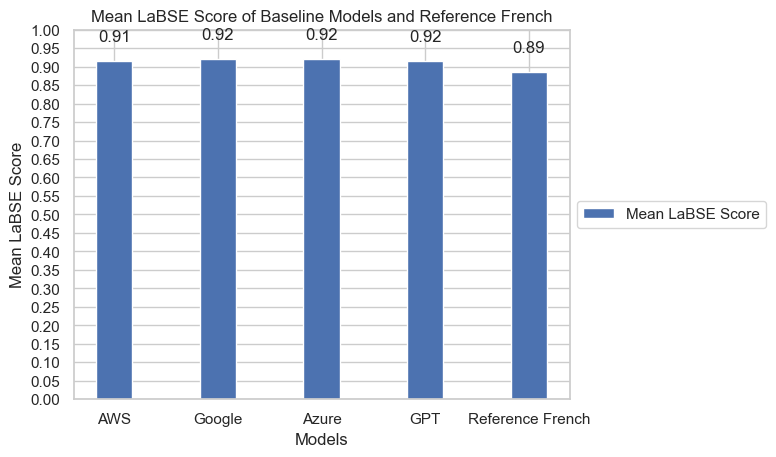

In [24]:
#graph the scores
import matplotlib.pyplot as plt

#bar plot
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(5)
aws_baseline_x = np.mean(aws_baseline.cpu().numpy())
google_baseline_x = np.mean(google_baseline.cpu().numpy())
azure_baseline_x = np.mean(azure_baseline.cpu().numpy())
gpt_baseline_x = np.mean(gpt_baseline.cpu().numpy())
reference_french_x = np.mean(reference_french.cpu().numpy())

#bar plot
bar1 = ax.bar(index, [aws_baseline_x, google_baseline_x, azure_baseline_x, gpt_baseline_x, reference_french_x], bar_width, label="Mean LaBSE Score")
ax.set_xlabel("Models")
ax.set_ylabel("Mean LaBSE Score")
ax.set_title("Mean LaBSE Score of Baseline Models and Reference French")
ax.set_xticks(index)
ax.set_xticklabels(["AWS", "Google", "Azure", "GPT", "Reference French"])
#choose y axis interval
plt.yticks(np.arange(0, 1.01, 0.05))
#put legend outside of plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#values on top of bars
for rect in bar1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%.2f' % height,
            ha='center', va='bottom')
plt.show()


In [28]:
#lets get the 5 lowest scores for each model
aws_baseline_scores = aws_baseline.cpu().numpy()
google_baseline_scores = google_baseline.cpu().numpy()
azure_baseline_scores = azure_baseline.cpu().numpy()
gpt_baseline_scores = gpt_baseline.cpu().numpy()
reference_french_scores = reference_french.cpu().numpy()

#indexes of the 5 lowest scores
aws_bottom_5 = np.argsort(aws_baseline_scores)[:5]
google_bottom_5 = np.argsort(google_baseline_scores)[:5]
azure_bottom_5 = np.argsort(azure_baseline_scores)[:5]
gpt_bottom_5 = np.argsort(gpt_baseline_scores)[:5]
reference_french_bottom_5 = np.argsort(reference_french_scores)[:5]

#print the 5 lowest scores
print("----------5 Lowest LaBSE Scores for AWS----------")
for i in aws_bottom_5:
    print(f"Index {i} with score {aws_baseline_scores[i]}")

print("----------5 Lowest LaBSE Scores for Google----------")
for i in google_bottom_5:
    print(f"Index {i} with score {google_baseline_scores[i]}")

print("----------5 Lowest LaBSE Scores for Azure----------")
for i in azure_bottom_5:
    print(f"Index {i} with score {azure_baseline_scores[i]}")

print("----------5 Lowest LaBSE Scores for GPT----------")
for i in gpt_bottom_5:
    print(f"Index {i} with score {gpt_baseline_scores[i]}")

print("----------5 Lowest LaBSE Scores for Reference French----------")
for i in reference_french_bottom_5:
    print(f"Index {i} with score {reference_french_scores[i]}")



----------5 Lowest LaBSE Scores for AWS----------
Index 822 with score 0.6263195276260376
Index 1554 with score 0.6461426615715027
Index 1829 with score 0.6605343222618103
Index 84 with score 0.6728281378746033
Index 612 with score 0.6970215439796448
----------5 Lowest LaBSE Scores for Google----------
Index 8 with score 0.5660627484321594
Index 84 with score 0.6458194851875305
Index 2637 with score 0.7104487419128418
Index 1155 with score 0.7222985029220581
Index 724 with score 0.7558120489120483
----------5 Lowest LaBSE Scores for Azure----------
Index 1658 with score 0.6013439297676086
Index 1155 with score 0.7308309674263
Index 968 with score 0.7354788184165955
Index 84 with score 0.7390486598014832
Index 2637 with score 0.7464686632156372
----------5 Lowest LaBSE Scores for GPT----------
Index 906 with score 0.6397724747657776
Index 674 with score 0.6652028560638428
Index 1659 with score 0.6894374489784241
Index 25 with score 0.6921236515045166
Index 2106 with score 0.700092911720

In [29]:
#lets get the 5 sentences at each of the indexes with the lowest scores
aws_bottom_5_sentences = [aws_data_v1[0].get_data()[i] for i in aws_bottom_5]
google_bottom_5_sentences = [google_data_v1[0].get_data()[i] for i in google_bottom_5]
azure_bottom_5_sentences = [azure_data_v1[0].get_data()[i] for i in azure_bottom_5]
gpt_bottom_5_sentences = [gpt_data_v1[0].get_data()[i] for i in gpt_bottom_5]
reference_french_bottom_5_sentences = [reference_corpus_fr.get_data()[i] for i in reference_french_bottom_5]


In [36]:
#lets get the english reference corpus sentences for the 5 lowest scores aws scores
reference_corpus_en_bottom_5 = [reference_corpus_en.get_data()[i] for i in aws_bottom_5]
reference_corpus_fr_bottom_5 = [reference_corpus_fr.get_data()[i] for i in aws_bottom_5]
reference_french_aws_5_LaBSE = [reference_french_scores[i] for i in aws_bottom_5]
for i in range(5):
    print(f"Original English Sentence:\n{reference_corpus_en_bottom_5[i]}")
    print(f"AWS Translated Sentence:\n{aws_bottom_5_sentences[i]}")
    print(f"AWS LaBSE Score {aws_baseline_scores[aws_bottom_5[i]]}")
    print(f"Original French Sentence:\n{reference_corpus_fr_bottom_5[i]}")
    print(f"Reference French LaBSE Score {reference_french_aws_5_LaBSE[i]}")
    print("---------------------------------------------------\n")

Original English Sentence:
The old basis of showing not telling.
AWS Translated Sentence:
L'ancienne méthode qui consiste à montrer qu'on ne dit rien.
AWS LaBSE Score 0.6263195276260376
Original French Sentence:
La base connue de ce que l'on montre et que l'on ne dit pas.
Reference French LaBSE Score 0.62649005651474
---------------------------------------------------

Original English Sentence:
Where does this leave Scotland?
AWS Translated Sentence:
Qu'en est-il de l'Écosse?
AWS LaBSE Score 0.6461426615715027
Original French Sentence:
Et l'Écosse, dans tout ça?
Reference French LaBSE Score 0.6264770030975342
---------------------------------------------------

Original English Sentence:
Nor are the types of people who use pawnbrokers only the financially stretched.
AWS Translated Sentence:
Les personnes qui font appel à des prêteurs sur gages ne sont pas non plus uniquement celles qui ont des difficultés financières.
AWS LaBSE Score 0.6605343222618103
Original French Sentence:
Les pe

In [37]:
#same for french reference corpus
reference_corpus_en_bottom_5 = [reference_corpus_en.get_data()[i] for i in reference_french_bottom_5]
aws_reference_bottom_5 = [aws_data_v1[0].get_data()[i] for i in reference_french_bottom_5]
aws_reference_5_LaBSE = [aws_baseline_scores[i] for i in reference_french_bottom_5]
for i in range(5):
    print(f"Original English Sentence:\n{reference_corpus_en_bottom_5[i]}")
    print(f"AWS Translated Sentence:\n{aws_reference_bottom_5[i]}")
    print(f"AWS LaBSE Score {aws_reference_5_LaBSE[i]}")
    print(f"Original French Sentence:\n{reference_french_bottom_5_sentences[i]}")
    print(f"Reference French LaBSE Score {reference_french_scores[reference_french_bottom_5[i]]}")
    print("---------------------------------------------------\n")

Original English Sentence:
A form, which - make no mistake - is just as restrictive,
AWS Translated Sentence:
Un formulaire qui, ne vous y trompez pas, est tout aussi restrictif,
AWS LaBSE Score 0.8859603404998779
Original French Sentence:
Mais ne nous y trompons pas, tout aussi contraignante.
Reference French LaBSE Score 0.41527771949768066
---------------------------------------------------

Original English Sentence:
It reveals that the wanderer liked to stay at home.
AWS Translated Sentence:
Cela révèle que le vagabond aimait rester chez lui.
AWS LaBSE Score 0.8513240814208984
Original French Sentence:
On y découvre que le chemineau était un casanier.
Reference French LaBSE Score 0.4160059094429016
---------------------------------------------------

Original English Sentence:
the jostling was unbelievable.
AWS Translated Sentence:
la bousculade était incroyable.
AWS LaBSE Score 0.8374006748199463
Original French Sentence:
Il y a une bousculade incroyable.
Reference French LaBSE Sc

#### Some notes:
The first translation of "A form, which - make no mistake - is just as restrictive". The term "form" is not present in the french translation: "Mais ne nous y trompons pas, tout aussi contraignante."
- The reference translations are different words rather than more literal translations impacting similarity:
    - "chemineau" v.s. "vagabond" (hobo)
    - "bête de scène" v.s. "grandes performances"
    - "volte-face" v.s. "revirement"

In [38]:
#same for french reference corpus
reference_corpus_en_bottom_5 = [reference_corpus_en.get_data()[i] for i in reference_french_bottom_5]
gpt_reference_bottom_5 = [gpt_data_v1[0].get_data()[i] for i in reference_french_bottom_5]
gpt_reference_5_LaBSE = [gpt_baseline_scores[i] for i in reference_french_bottom_5]
for i in range(5):
    print(f"Original English Sentence:\n{reference_corpus_en_bottom_5[i]}")
    print(f"GPT Translated Sentence:\n{gpt_reference_bottom_5[i]}")
    print(f"GPT LaBSE Score {gpt_reference_5_LaBSE[i]}")
    print(f"Original French Sentence:\n{reference_french_bottom_5_sentences[i]}")
    print(f"Reference French LaBSE Score {reference_french_scores[reference_french_bottom_5[i]]}")
    print("---------------------------------------------------\n")

Original English Sentence:
A form, which - make no mistake - is just as restrictive,
GPT Translated Sentence:
Un formulaire, qui - ne vous méprenez pas - est tout aussi restrictif,
GPT LaBSE Score 0.877363383769989
Original French Sentence:
Mais ne nous y trompons pas, tout aussi contraignante.
Reference French LaBSE Score 0.41527771949768066
---------------------------------------------------

Original English Sentence:
It reveals that the wanderer liked to stay at home.
GPT Translated Sentence:
Cela révèle que le voyageur aimait rester à la maison.
GPT LaBSE Score 0.7861011028289795
Original French Sentence:
On y découvre que le chemineau était un casanier.
Reference French LaBSE Score 0.4160059094429016
---------------------------------------------------

Original English Sentence:
the jostling was unbelievable.
GPT Translated Sentence:
Le bousculade était incroyable.
GPT LaBSE Score 0.7874686121940613
Original French Sentence:
Il y a une bousculade incroyable.
Reference French LaBS

In [ ]:
# Original English Sentence:
# the jostling was unbelievable.
# GPT Translated Sentence:
# Le bousculade était incroyable. THIS IS WRONG Bousculade nom féminin
# GPT LaBSE Score 0.7874686121940613
# Original French Sentence:
# Il y a une bousculade incroyable.
# Reference French LaBSE Score 0.47718217968940735